In [1]:
import torch
from torch import nn

import torch.multiprocessing as mp

import numpy as np

from tictactoe import TicTacToe, match_players, plot_test_game

from players import RandomPlayer, TablePlayer, MCTSPlayer, DQNPlayer, DoubleDQNPlayer, AlphaZeroPlayer

from episode_server import EpisodeServer

from utils import PriorityMemory, break_episode_to_transitions

from copy import deepcopy

import time

import pickle

In [2]:
env = TicTacToe(3,3,3)
random_player = RandomPlayer(3,3,3)
mcts_player = MCTSPlayer(3,3,3)

In [13]:
match_players(env, mcts_player, mcts_player, 1000)

(0.30522088353413657, -0.27610441767068267)

In [3]:
table_player = TablePlayer(3,3,3, eps=0.2)

In [5]:
epochs = 20
updates_per_epoch = 10000
match_games = 1000

episode_server = EpisodeServer(env, table_player, num_workers=10, max_buffer_size=10000)

episode_server.start()

time.sleep(2)

print("Average rewards against previous version:")
for epoch in range(epochs):
    old_table_player = deepcopy(table_player)
    updates = 0
    while True:
        episodes = episode_server.get_episodes()
        for ep in episodes:
            transitions = break_episode_to_transitions(ep)
            table_player.update_Q(transitions)
            updates += len(transitions)

            if updates > updates_per_epoch:
                break
        if updates > updates_per_epoch:
            break
            
    episode_server.update_player(table_player)
    
    cross_reward, naught_reward = match_players(env, table_player, old_table_player, match_games)
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average rewards against previous version:
Cross: 0.804, naught: 0.430
Cross: 0.591, naught: 0.285
Cross: 0.685, naught: 0.212
Cross: 0.574, naught: 0.285
Cross: 0.516, naught: -0.103
Cross: 0.514, naught: -0.080
Cross: 0.141, naught: -0.061
Cross: 0.406, naught: -0.219
Cross: 0.515, naught: -0.070
Cross: 0.107, naught: -0.073
Cross: 0.540, naught: -0.149
Cross: 0.607, naught: -0.110
Cross: 0.085, naught: -0.107
Cross: 0.152, naught: -0.097
Cross: 0.103, naught: -0.123
Cross: 0.077, naught: -0.127
Cross: 0.108, naught: -0.076
Cross: 0.127, naught: -0.100
Cross: 0.097, naught: -0.080
Cross: 0.144, naught: -0.124


In [6]:
table_player.eps = 0

In [7]:
match_players(env, table_player, random_player, 1000)

(0.9849397590361445, 0.9236947791164659)

In [8]:
match_players(env, table_player, mcts_player, 1000)

(0.6696787148594376, 0.11947791164658635)

In [8]:
env = TicTacToe(4,4,4)
random_player = RandomPlayer(4,4,4)
mcts_player = MCTSPlayer(4,4,4)
table_player = TablePlayer(4,4,4, eps=0.2)

In [9]:
epochs = 20
updates_per_epoch = 10000
match_games = 1000

episode_server = EpisodeServer(env, table_player, num_workers=10, max_buffer_size=10000)

episode_server.start()

print("Average rewards against previous version:")
for epoch in range(epochs):
    old_table_player = deepcopy(table_player)
    updates = 0
    while True:
        episodes = episode_server.get_episodes()
        for ep in episodes:
            transitions = break_episode_to_transitions(ep)
            table_player.update_Q(transitions)
            updates += len(transitions)

            if updates > updates_per_epoch:
                break
        if updates > updates_per_epoch:
            break
            
    episode_server.update_player(table_player)
    
    cross_reward, naught_reward = match_players(env, table_player, old_table_player, match_games)
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average rewards against previous version:
Cross: 0.060, naught: -0.040
Cross: 0.016, naught: -0.045
Cross: 0.053, naught: -0.055
Cross: 0.020, naught: -0.082
Cross: 0.086, naught: -0.056
Cross: 0.040, naught: -0.045
Cross: 0.049, naught: -0.019
Cross: 0.021, naught: -0.061
Cross: 0.095, naught: -0.035
Cross: 0.091, naught: -0.060
Cross: 0.091, naught: -0.083
Cross: 0.075, naught: -0.092
Cross: 0.068, naught: -0.060
Cross: 0.037, naught: -0.013
Cross: 0.028, naught: -0.023
Cross: 0.039, naught: -0.064
Cross: 0.095, naught: -0.077
Cross: 0.120, naught: -0.098
Cross: 0.175, naught: -0.046
Cross: 0.193, naught: 0.022


In [15]:
table_player.eps = 0

In [23]:
match_players(env, random_player, random_player, 1000)

(0.04618473895582329, -0.07730923694779115)

In [16]:
match_players(env, table_player, random_player, 1000)

(0.10441767068273093, -0.06024096385542168)

In [19]:
match_players(env, mcts_player, random_player, 1000)

(0.9166666666666669, 0.8102409638554217)

In [24]:
match_players(env, table_player, mcts_player, 1000)

(-0.8092369477911646, -0.9066265060240966)

In [2]:
DEVICE = 'cuda:0'

In [3]:
env = TicTacToe(3,3,3)
random_player = RandomPlayer(3,3,3)
mcts_player = MCTSPlayer(3,3,3)

In [4]:
dqn_player = DQNPlayer(3, 3, 3, gamma=1.0).to(DEVICE)

In [5]:
epochs = 20
updates_per_epoch = 500
batch_size = 256
match_games = 1000

episode_server = EpisodeServer(env, dqn_player, num_workers=10, max_buffer_size=10000)
memory = PriorityMemory(size=5000)

dqn_player.configure_optimizer(lr=3e-4)

episode_server.start()

time.sleep(2)

for epoch in range(epochs):
    old_dqn_player = deepcopy(dqn_player)
    dqn_player.train()

    episodes = episode_server.get_episodes()
    for ep in episodes:
        transitions = break_episode_to_transitions(ep)
        transitions_with_losses = [
            (tr, float("inf")) for tr in transitions
        ]
        memory.put(transitions_with_losses)

    losses = []
    for _ in range(updates_per_epoch):
        transitions = memory.get(batch_size)
        _losses = dqn_player.update_Q(transitions)

        transitions_with_losses = [
            (tr, _loss) for tr, _loss in zip(transitions, _losses)
        ]
        memory.put(transitions_with_losses)

        losses.append(_losses.mean())

    losses = np.array(losses)
    print(f"Average loss: {losses.mean()}")
            
    episode_server.update_player(dqn_player)
    
    cross_reward, naught_reward = match_players(env, dqn_player, old_dqn_player, match_games)
    print("Average rewards against previous version:")
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average loss: 0.11050592362880707
Average rewards against previous version:
Cross: 0.727, naught: -0.531
Average loss: 0.08858031034469604
Average rewards against previous version:
Cross: 0.957, naught: 0.424
Average loss: 0.09578096866607666
Average rewards against previous version:
Cross: 0.155, naught: 0.496
Average loss: 0.12834784388542175
Average rewards against previous version:
Cross: -0.495, naught: 0.544
Average loss: 0.12489165365695953
Average rewards against previous version:
Cross: 0.884, naught: 0.596
Average loss: 0.06084494665265083
Average rewards against previous version:
Cross: 0.936, naught: 0.613
Average loss: 0.12876540422439575
Average rewards against previous version:
Cross: 0.877, naught: 0.449
Average loss: 0.06059582903981209
Average rewards against previous version:
Cross: 0.763, naught: -0.641
Average loss: 0.05655015632510185
Average rewards against previous version:
Cross: 0.780, naught: 0.542
Average loss: 0.09968037158250809
Average rewards against pre

In [6]:
dqn_player.eps = 0

In [7]:
match_players(env, dqn_player, random_player, match_games)

(0.967871485943775, 0.7028112449799196)

In [8]:
match_players(env, dqn_player, mcts_player, match_games)

(0.2108433734939759, -0.44477911646586343)

In [2]:
DEVICE = 'cuda:0'

In [3]:
env = TicTacToe(4,4,4)
random_player = RandomPlayer(4,4,4)
mcts_player = MCTSPlayer(4,4,4)

In [4]:
double_dqn_player = DoubleDQNPlayer(4, 4, 4, gamma=1.0, net_config={
    "type": "dueling_dqn"
}).to(DEVICE)

In [5]:
epochs = 20
updates_per_epoch = 100
batch_size = 256
match_games = 1000

episode_server = EpisodeServer(env, double_dqn_player, num_workers=10, max_buffer_size=10000)
memory = PriorityMemory(size=5000)

double_dqn_player.configure_optimizer(lr=3e-4)

episode_server.start()

time.sleep(2)

for epoch in range(epochs):
    old_double_dqn_player = deepcopy(double_dqn_player)
    double_dqn_player.train()

    episodes = episode_server.get_episodes()
    for ep in episodes:
        transitions = break_episode_to_transitions(ep)
        transitions_with_losses = [
            (tr, float("inf")) for tr in transitions
        ]
        memory.put(transitions_with_losses)

    losses = []
    for _ in range(updates_per_epoch):
        transitions = memory.get(batch_size)
        _losses = double_dqn_player.update_Q(transitions)

        transitions_with_losses = [
            (tr, _loss) for tr, _loss in zip(transitions, _losses)
        ]
        memory.put(transitions_with_losses)

        losses.append(_losses.mean())

    losses = np.array(losses)
    print(f"Average loss: {losses.mean()}")
            
    double_dqn_player.update_target_dqn()
    episode_server.update_player(double_dqn_player)
    
    cross_reward, naught_reward = match_players(env, double_dqn_player, old_double_dqn_player, match_games)
    print("Average rewards against previous version:")
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average loss: 0.11139730364084244
Average rewards against previous version:
Cross: -0.883, naught: -0.786
Average loss: 0.045526739209890366
Average rewards against previous version:
Cross: 0.497, naught: 0.213
Average loss: 0.07619491964578629
Average rewards against previous version:
Cross: -0.531, naught: -0.321
Average loss: 0.07402683794498444
Average rewards against previous version:
Cross: 0.053, naught: -0.376
Average loss: 0.0739252045750618
Average rewards against previous version:
Cross: 0.013, naught: -0.018
Average loss: 0.06027382239699364
Average rewards against previous version:
Cross: 0.394, naught: -0.811
Average loss: 0.06688202172517776
Average rewards against previous version:
Cross: 0.353, naught: -0.623
Average loss: 0.0632007047533989
Average rewards against previous version:
Cross: 0.839, naught: -0.269
Average loss: 0.05295645818114281
Average rewards against previous version:
Cross: 0.751, naught: 0.294
Average loss: 0.05144551768898964
Average rewards agains

In [6]:
double_dqn_player.eps = 0

In [7]:
match_players(env, double_dqn_player, random_player, match_games)

(0.8674698795180723, 0.8022088353413653)

In [8]:
match_players(env, double_dqn_player, mcts_player, match_games)

(-0.24397590361445778, -0.5160642570281123)

In [2]:
DEVICE = 'cuda:0'

In [3]:
env = TicTacToe(3,3,3)
random_player = RandomPlayer(3,3,3)
mcts_player = MCTSPlayer(3,3,3)

In [4]:
num_simulations=100
alphazero_player = AlphaZeroPlayer(
    3,3,3,num_simulations=num_simulations, eps=0.2, exploration_parameter=0.5
).to(DEVICE)

In [5]:
epochs = 10
updates_per_epoch = 300
batch_size = 256
match_games = 100

episode_server = EpisodeServer(env, alphazero_player, num_workers=10, max_buffer_size=10000, zero_mode=True)
memory = PriorityMemory(size=5000)

alphazero_player.configure_optimizer(lr=3e-4)

episode_server.start()

time.sleep(2)

for epoch in range(epochs):
    old_alphazero_player = deepcopy(alphazero_player)
    alphazero_player.train()

    episodes = episode_server.get_episodes()
    for ep in episodes:
        transitions = ep
        transitions_with_losses = [
            (tr, float("inf")) for tr in transitions
        ]
        memory.put(transitions_with_losses)

    losses = []
    for _ in range(updates_per_epoch):
        transitions = memory.get(batch_size)
        _losses = alphazero_player.update_Q(transitions)

        transitions_with_losses = [
            (tr, _loss) for tr, _loss in zip(transitions, _losses)
        ]
        memory.put(transitions_with_losses)

        losses.append(_losses.mean())

    losses = np.array(losses)
    print(f"Average loss: {losses.mean()}")
            
    episode_server.update_player(alphazero_player)
    
    ##reducing simulations number for validation
    alphazero_player.set_params(num_simulations=5)
    old_alphazero_player.set_params(num_simulations=5)
    
    cross_reward, naught_reward = match_players(env, alphazero_player, old_alphazero_player, match_games)
    
    alphazero_player.set_params(num_simulations=num_simulations)
    print("Average rewards against previous version:")
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average loss: 0.376135915517807
Average rewards against previous version:
Cross: 0.792, naught: 0.073
Average loss: 0.6087122559547424
Average rewards against previous version:
Cross: 0.521, naught: -0.271
Average loss: 0.6473291516304016
Average rewards against previous version:
Cross: 0.302, naught: -0.406
Average loss: 0.638034999370575
Average rewards against previous version:
Cross: 0.500, naught: -0.344
Average loss: 0.6648396849632263
Average rewards against previous version:
Cross: 0.406, naught: -0.312
Average loss: 0.6837815642356873
Average rewards against previous version:
Cross: 0.469, naught: -0.312
Average loss: 0.6478744745254517
Average rewards against previous version:
Cross: 0.156, naught: -0.146
Average loss: 0.6302633881568909
Average rewards against previous version:
Cross: 0.156, naught: -0.167
Average loss: 0.619746208190918
Average rewards against previous version:
Cross: 0.208, naught: -0.146
Average loss: 0.6088365912437439
Average rewards against previous ve

In [6]:
alphazero_player.eps = 0

In [7]:
match_players(env, alphazero_player, random_player, match_games)

(0.96875, 0.90625)

In [8]:
match_players(env, alphazero_player, mcts_player, match_games)

(0.4166666666666667, 0.10416666666666667)

In [9]:
DEVICE = 'cuda:0'

In [10]:
env = TicTacToe(4,4,4)
random_player = RandomPlayer(4,4,4)
mcts_player = MCTSPlayer(4,4,4)

In [11]:
num_simulations = 100
alphazero_player = AlphaZeroPlayer(
    4,4,4,num_simulations=num_simulations, eps=0.2, exploration_parameter=0.5
).to(DEVICE)

In [12]:
epochs = 20
updates_per_epoch = 300
batch_size = 256
match_games = 100

episode_server = EpisodeServer(env, alphazero_player, num_workers=12, max_buffer_size=10000, zero_mode=True)
memory = PriorityMemory(size=5000)

alphazero_player.configure_optimizer(lr=3e-4)

episode_server.start()

time.sleep(2)

for epoch in range(epochs):
    old_alphazero_player = deepcopy(alphazero_player)
    alphazero_player.train()

    episodes = episode_server.get_episodes()
    for ep in episodes:
        transitions = ep
        transitions_with_losses = [
            (tr, float("inf")) for tr in transitions
        ]
        memory.put(transitions_with_losses)

    losses = []
    for _ in range(updates_per_epoch):
        transitions = memory.get(batch_size)
        _losses = alphazero_player.update_Q(transitions)

        transitions_with_losses = [
            (tr, _loss) for tr, _loss in zip(transitions, _losses)
        ]
        memory.put(transitions_with_losses)

        losses.append(_losses.mean())

    losses = np.array(losses)
    print(f"Average loss: {losses.mean()}")
            
    episode_server.update_player(alphazero_player)
    
    ##reducing simulations number for validation
    alphazero_player.set_params(num_simulations=5)
    old_alphazero_player.set_params(num_simulations=5)
    
    cross_reward, naught_reward = match_players(env, alphazero_player, old_alphazero_player, match_games)
    
    alphazero_player.set_params(num_simulations=num_simulations)
    print("Average rewards against previous version:")
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average loss: 1.0162384510040283
Average rewards against previous version:
Cross: 0.031, naught: -0.083
Average loss: 1.2191611528396606
Average rewards against previous version:
Cross: 0.229, naught: -0.052
Average loss: 1.1615692377090454
Average rewards against previous version:
Cross: 0.188, naught: -0.021
Average loss: 1.1260699033737183
Average rewards against previous version:
Cross: 0.229, naught: -0.021
Average loss: 1.0963495969772339
Average rewards against previous version:
Cross: 0.188, naught: 0.062
Average loss: 1.0254559516906738
Average rewards against previous version:
Cross: -0.021, naught: 0.167
Average loss: 0.9921959638595581
Average rewards against previous version:
Cross: 0.219, naught: -0.115
Average loss: 0.9616814255714417
Average rewards against previous version:
Cross: 0.104, naught: -0.000
Average loss: 0.9299123883247375
Average rewards against previous version:
Cross: 0.010, naught: -0.000
Average loss: 0.9326058030128479
Average rewards against previous

In [13]:
alphazero_player.set_params(eps=0.0)

In [14]:
match_players(env, alphazero_player, random_player, match_games)

(0.8958333333333334, 0.84375)

In [15]:
match_players(env, alphazero_player, mcts_player, match_games)

(0.07291666666666667, -0.010416666666666666)

In [16]:
alphazero_player.reset()
alphazero_player = alphazero_player.cpu().eval()

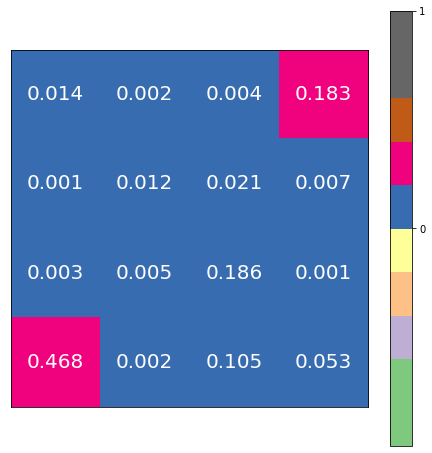

0 (0, 0) 0.00787878787878788
1 (0, 1) 0.0009090909090909091
2 (0, 2) 0.0024242424242424242
3 (0, 3) 0.16727272727272727
4 (1, 0) 0.0009090909090909091
5 (1, 1) 0.008181818181818182
6 (1, 2) 0.019696969696969695
7 (1, 3) 0.0048484848484848485
8 (2, 0) 0.005151515151515152
9 (2, 1) 0.006666666666666667
10 (2, 2) 0.1618181818181818
11 (2, 3) 0.0009090909090909091
12 (3, 0) 0.45606060606060606
13 (3, 1) 0.0015151515151515152
14 (3, 2) 0.10303030303030303
15 (3, 3) 0.05272727272727273


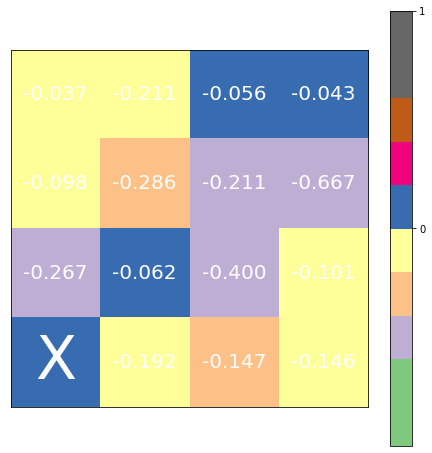

0 (0, 0) -0.06811989100817438
1 (0, 1) -0.13953488372093023
2 (0, 2) -0.08235294117647057
3 (0, 3) -0.06963249516441006
4 (1, 0) -0.11290322580645161
5 (1, 1) -0.2857142857142857
6 (1, 2) -0.25000000000000006
7 (1, 3) -0.6666666666666666
8 (2, 0) -0.2666666666666666
9 (2, 1) -0.05079605761940864
10 (2, 2) -0.4
11 (2, 3) -0.10112359550561796
12 (3, 1) -0.1923076923076923
13 (3, 2) -0.1470588235294118
14 (3, 3) -0.14634146341463417


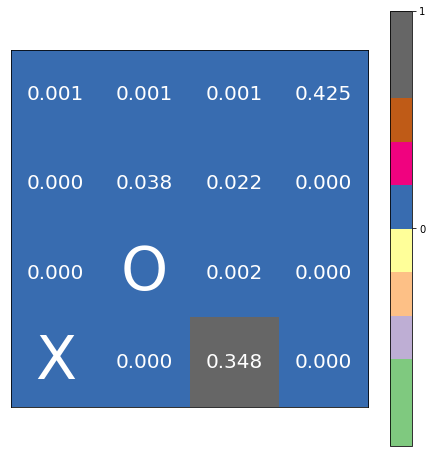

0 (0, 0) 0.00034458993797381116
1 (0, 1) 0.00034458993797381116
2 (0, 2) 0.00034458993797381116
3 (0, 3) 0.5926946933149552
4 (1, 0) 0.0
5 (1, 1) 0.026878015161957272
6 (1, 2) 0.018952446588559616
7 (1, 3) 0.00034458993797381116
8 (2, 0) 0.00034458993797381116
9 (2, 2) 0.0017229496898690559
10 (2, 3) 0.00034458993797381116
11 (3, 1) 0.002067539627842867
12 (3, 2) 0.3552722260509993
13 (3, 3) 0.00034458993797381116


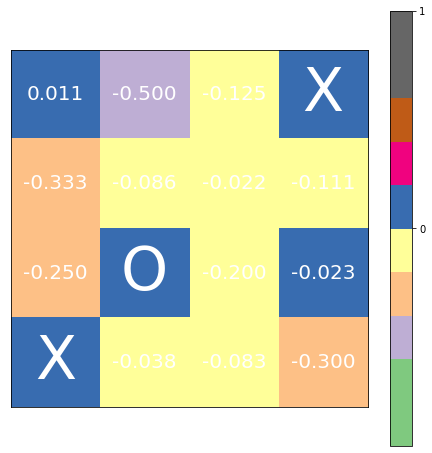

0 (0, 0) -0.01736613603473228
1 (0, 1) -0.5
2 (0, 2) -0.15384615384615383
3 (1, 0) -0.33333333333333337
4 (1, 1) -0.10526315789473682
5 (1, 2) -0.04545454545454545
6 (1, 3) -0.07692307692307693
7 (2, 0) -0.3076923076923077
8 (2, 2) -0.16666666666666666
9 (2, 3) -0.020979020979020987
10 (3, 1) -0.04464285714285713
11 (3, 2) -0.08333333333333336
12 (3, 3) -0.3


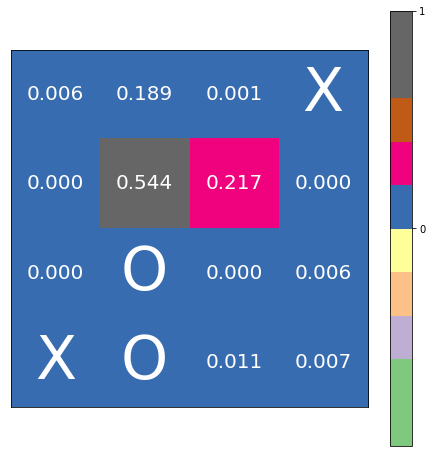

0 (0, 0) 0.020795330171470266
1 (0, 1) 0.2867566581539584
2 (0, 2) 0.00036483035388544326
3 (1, 0) 0.0
4 (1, 1) 0.44910616563298067
5 (1, 2) 0.17803721269609632
6 (1, 3) 0.0
7 (2, 0) 0.0
8 (2, 2) 0.00036483035388544326
9 (2, 3) 0.005472455308281649
10 (3, 2) 0.05253557095950383
11 (3, 3) 0.006566946369937978


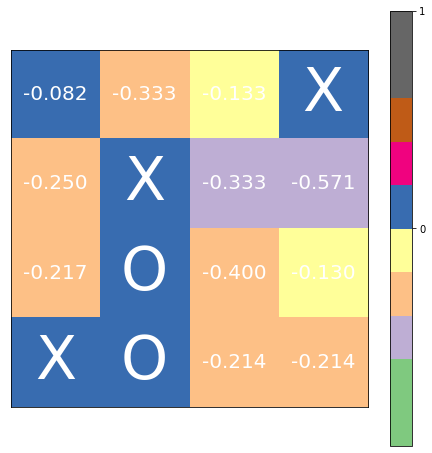

0 (0, 0) -0.05991013479780329
1 (0, 1) -0.3333333333333333
2 (0, 2) -0.13253012048192772
3 (1, 0) -0.25
4 (1, 2) -0.3333333333333333
5 (1, 3) -0.5714285714285714
6 (2, 0) -0.21739130434782605
7 (2, 2) -0.4
8 (2, 3) -0.12987012987012986
9 (3, 2) -0.21428571428571425
10 (3, 3) -0.2142857142857143


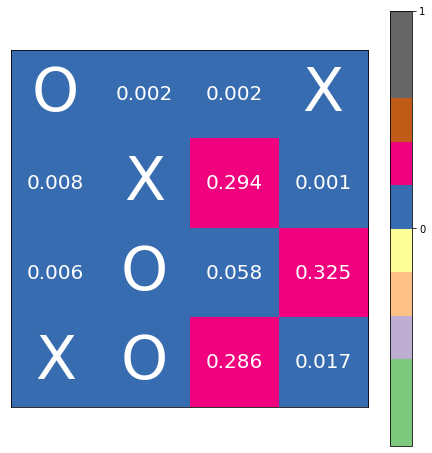

0 (0, 1) 0.0009478672985781991
1 (0, 2) 0.0033175355450236967
2 (1, 0) 0.0071090047393364926
3 (1, 2) 0.35924170616113743
4 (1, 3) 0.006635071090047393
5 (2, 0) 0.005213270142180095
6 (2, 2) 0.05023696682464455
7 (2, 3) 0.2909952606635071
8 (3, 2) 0.26018957345971566
9 (3, 3) 0.016113744075829384


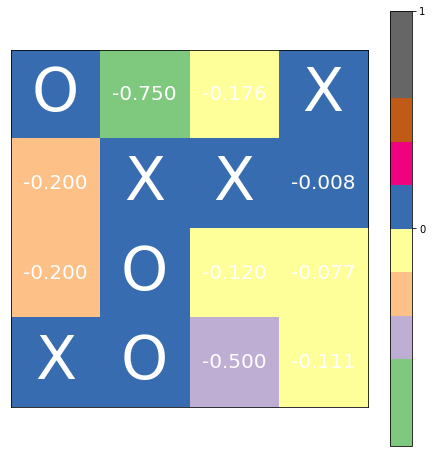

0 (0, 1) -0.75
1 (0, 2) -0.1764705882352941
2 (1, 0) -0.2
3 (1, 3) -0.00453514739229025
4 (2, 0) -0.2
5 (2, 2) -0.12
6 (2, 3) -0.07692307692307696
7 (3, 2) -0.5
8 (3, 3) -0.11111111111111109


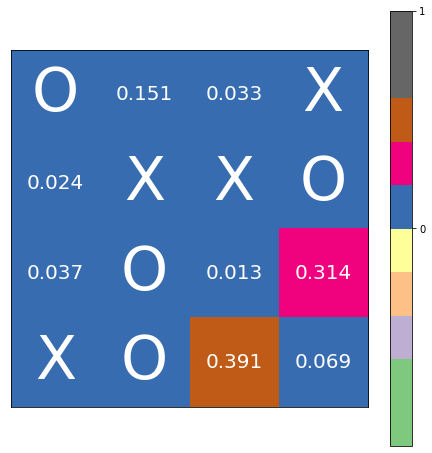

0 (0, 1) 0.14588235294117646
1 (0, 2) 0.04411764705882353
2 (1, 0) 0.02
3 (2, 0) 0.036470588235294116
4 (2, 2) 0.027647058823529413
5 (2, 3) 0.2958823529411765
6 (3, 2) 0.3629411764705882
7 (3, 3) 0.06705882352941177


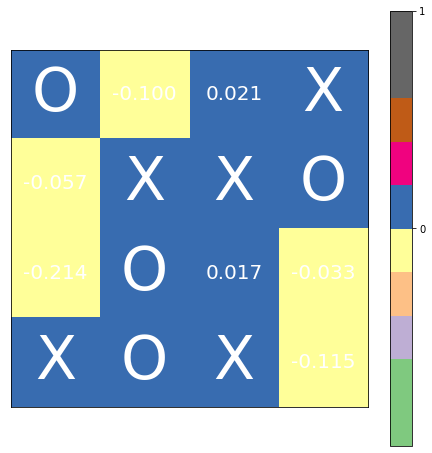

0 (0, 1) -0.07894736842105263
1 (0, 2) 0.013136288998357969
2 (1, 0) -0.08333333333333334
3 (2, 0) -0.21428571428571427
4 (2, 2) 0.014371257485029942
5 (2, 3) -0.03333333333333333
6 (3, 3) -0.11538461538461539


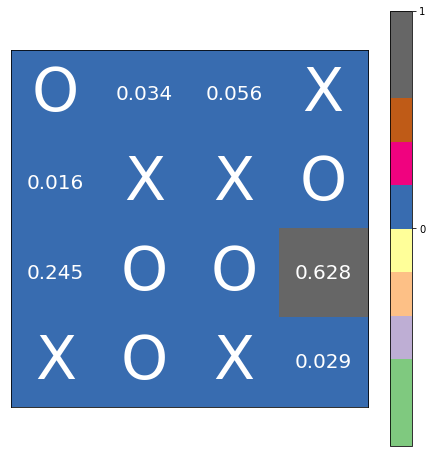

0 (0, 1) 0.01841903300076746
1 (0, 2) 0.039907904834996163
2 (1, 0) 0.010744435917114352
3 (2, 0) 0.2640061396776669
4 (2, 3) 0.6400613967766692
5 (3, 3) 0.02686108979278588


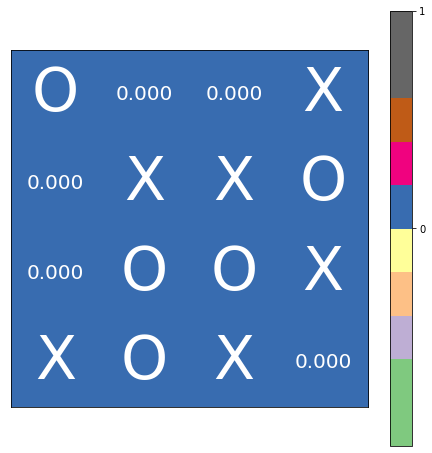

0 (0, 1) 0.0
1 (0, 2) 0.0
2 (1, 0) 0.0
3 (2, 0) 0.0
4 (3, 3) 0.0


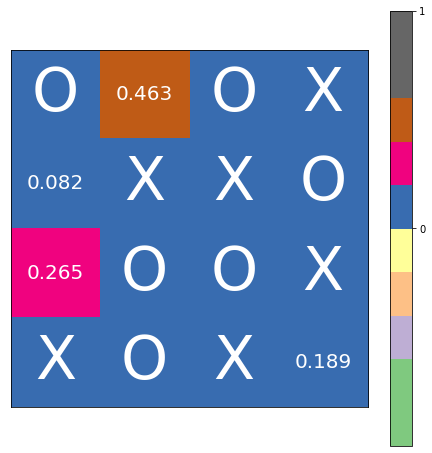

0 (0, 1) 0.46503884572697
1 (1, 0) 0.07769145394006659
2 (2, 0) 0.26970033296337403
3 (3, 3) 0.18756936736958935


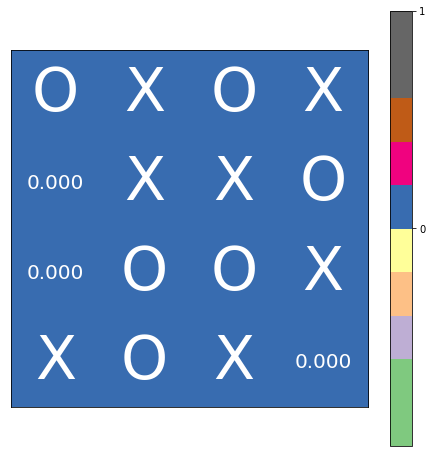

0 (1, 0) 0.0
1 (2, 0) 0.0
2 (3, 3) 0.0


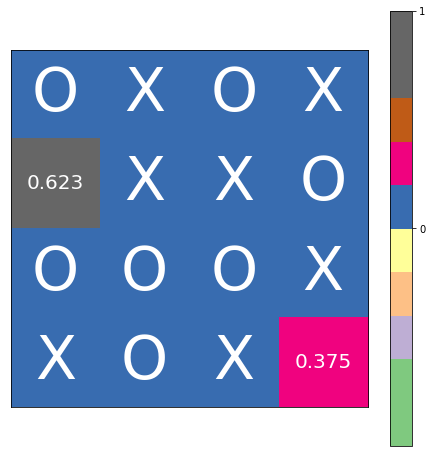

0 (1, 0) 0.6256742179072277
1 (3, 3) 0.3743257820927724


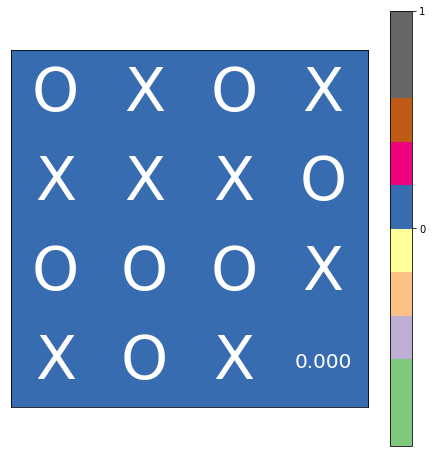

0 (3, 3) 0.0


In [17]:
with torch.no_grad():
    plot_test_game(env, alphazero_player, mcts_player, random_naughts=False)

P.S. При вызове alphazero_player.get_Q заново запускаются MCTS симуляции. Так как этот метод зовётся в функции отрисовки несколько раз, ход и максимум очков на картинке немного не совпадают. Для alphazero get_Q выдаёт policy(a|s), а не Q(a|s).